# Pipeline
### Prepare data

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data',
                 header = None)

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 1)

### construct pipeline
- train, test를 각각 변환하지 않고 파이프라인으로 연결할 수 있다.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression(solver = 'liblinear', random_state = 1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(f"테스트 정확도 : {pipe_lr.score(X_test, y_test)}")

테스트 정확도 : 0.956140350877193


- pipeline클래스로 변환기와 추정기를 감싼 wrapper로 생각할 수 있다.
- pipeline의 마지막 요소는 추정기가 돼야 한다.

# KFold cross-validation

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f"폴드: {k+1}, 클래스 분포: {np.bincount(y_train[train])}, 정확도: {round(score, 3)}")

print(f"CV 정확도: {np.mean(scores)} +/- {np.std(scores)}")

폴드: 1, 클래스 분포: [256 153], 정확도: 0.913
폴드: 2, 클래스 분포: [256 153], 정확도: 1.0
폴드: 3, 클래스 분포: [256 153], 정확도: 0.957
폴드: 4, 클래스 분포: [256 153], 정확도: 0.978
폴드: 5, 클래스 분포: [256 153], 정확도: 0.87
폴드: 6, 클래스 분포: [257 153], 정확도: 0.933
폴드: 7, 클래스 분포: [257 153], 정확도: 0.956
폴드: 8, 클래스 분포: [257 153], 정확도: 0.978
폴드: 9, 클래스 분포: [257 153], 정확도: 0.978
폴드: 10, 클래스 분포: [257 153], 정확도: 0.911
CV 정확도: 0.9472946859903383 +/- 0.03803650729783967


# KFold cross_val_score

In [7]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator = pipe_lr, X = X_train,
                         y = y_train, cv = 10, n_jobs = -1)

print(f"CV 정확도 점수 : {scores}")
print(f"CV 정확도: {np.mean(scores)} +/- {np.std(scores)}")

CV 정확도 점수 : [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.9495169082125603 +/- 0.013854294239660376


In [8]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator = pipe_lr, X = X_train,
                        y = y_train, scoring = ['accuracy'],
                        cv = 10, n_jobs = -1, return_train_score = False)
print(f"CV 정확도 점수 : {scores['test_accuracy']}")
print(f"CV 정확도: {np.mean(scores['test_accuracy'])} +/- {np.std(scores['test_accuracy'])}")

CV 정확도 점수 : [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.9495169082125603 +/- 0.013854294239660376


# 학습 곡선과 검증 곡선
- 그래프를 통해 분산과 편향의 문제점을 확인할 수 있다.

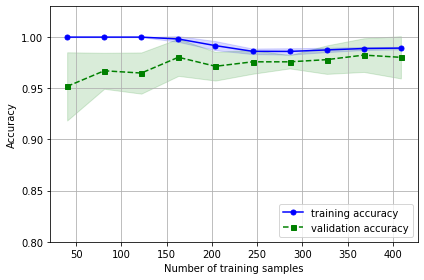

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver = 'liblinear',
                                           penalty = 'l2',
                                           random_state = 1))

train_sizes, train_scores, test_scores = learning_curve(estimator = pipe_lr,
                                                        X = X_train,
                                                        y = y_train,
                                                        # linspace로 일정간격 훈련세트의 비율선택
                                                        train_sizes = np.linspace(
                                                        0.1, 1.0, 10),
                                                        cv = 10,
                                                        n_jobs = 1)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_mean,
         color = 'blue', marker = 'o',
         markersize = 5, label = 'training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color = 'blue')

plt.plot(train_sizes, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5,
         label = 'validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

# 검증 곡선으로 과대적합 과소적합 검사
- 검증곡선은 훈련, 테스트 정확도 대신에 모델 파라미터 값의 함수로 그린다.

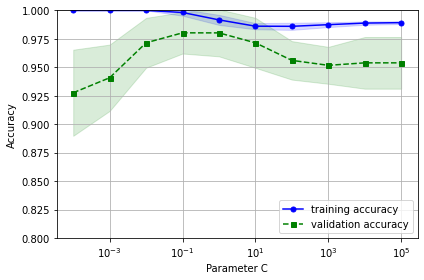

In [10]:
# logistic regression's hyper-parameter : C
from sklearn.model_selection import validation_curve

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
trian_scores, test_scores = validation_curve(estimator = pipe_lr,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'logisticregression__C',
                                             param_range = param_range,
                                             cv = 10)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(param_range, train_mean,
         color = 'blue', marker = 'o',
         markersize = 5, label = 'training accuracy')

plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color = 'blue')

plt.plot(param_range, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5,
         label = 'validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

- validation curve 함수 안에 평가하고자 하는 매개변수를 지정
- param_range : 매개변수에는 값 범위 지정

# Gridsearch
- 리스트로 지정된 여러 가지 hyper-parameter값 전체를 조사한다.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state = 1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C':param_range,
               'svc__kernel':['linear']},
              {'svc__C':param_range,
               'svc__gamma':param_range,
               'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  n_jobs = -1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [12]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f"테스트 정확도 : {round(clf.score(X_test, y_test), 3)}")

테스트 정확도 : 0.974


# 중첩 교차 검증

In [13]:
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print("cv 정확도 : ", np.mean(scores), np.std(scores))

cv 정확도 :  0.9736263736263737 0.014906219743132467


In [14]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0),
                  param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring = 'accuracy',
                  cv = 2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print("cv 정확도 : ", np.mean(scores), np.std(scores))

cv 정확도 :  0.9340659340659341 0.015540808377726326


# confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


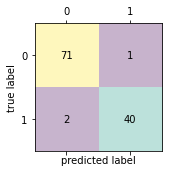

In [16]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i,
                s = confmat[i, j],
                va = 'center', ha = 'center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

# recall_score, f1_score

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('정밀도: %.3f' %precision_score(y_true = y_test, y_pred = y_pred))

print('재현율: %.3f' %recall_score(y_true = y_test, y_pred = y_pred))

print('F1: %.3f' %f1_score(y_true = y_test, y_pred = y_pred))

정밀도: 0.976
재현율: 0.952
F1: 0.964


### gridsearch scoring

In [18]:
from sklearn.metrics import make_scorer, f1_score

scorer = make_scorer(f1_score, pos_label = 0)
c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C':c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C':c_gamma_range,
               'svc__gamma':c_gamma_range,
               'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 10)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### roc-auc

c:\users\xnoti\anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
c:\users\xnoti\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
c:\users\xnoti\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
c:\users\xnoti\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


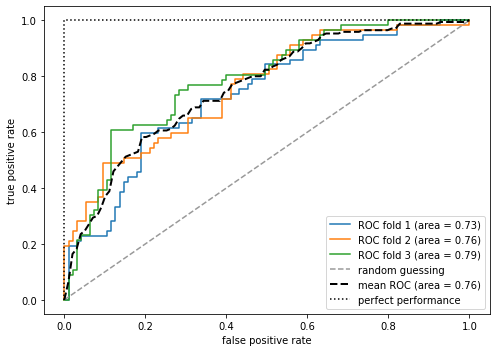

In [19]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression(solver = 'liblinear', penalty = 'l2', random_state = 1, C=100.0))

X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits = 3, random_state = 1).split(X_train, y_train))

fig = plt.figure(figsize = (7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label = 1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label = 'mean ROC (area = %0.2f)' % mean_auc, lw = 2)

plt.plot([0,0,1],
         [0,1,1],
         linestyle = ':',
         color = 'black',
         label = 'perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()

# sampling data

In [28]:
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

print('샘플링하기 전 클래스 1의 샘플개수', X_imb[y_imb == 1].shape[0])
print('샘플링하기 전 클래스 0의 샘플개수', X_imb[y_imb == 0].shape[0])

샘플링하기 전 클래스 1의 샘플개수 40
샘플링하기 전 클래스 0의 샘플개수 357


### resampling

In [24]:
from sklearn.utils import resample

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], replace = True,
                                    n_samples = X_imb[y_imb==0].shape[0], random_state = 123)
print('샘플링 후 클래스 1의 샘플개수', X_upsampled.shape[0])

샘플링 후 클래스 1의 샘플개수 357


In [25]:
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0